In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(3)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.13:60427 Dashboard: http://10.148.1.13:8787/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


# oceFWflx

In [5]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

# variable 
v = 'oceFWflx'

In [8]:
# search for right files, for example: Theta_177x201x52.*
filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201.*')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds = np.fromfile(filenames[i] , dtype='>f').reshape(201,177)
        ds = np.array(ds)
        ds = xr.DataArray(ds, dims=['lat','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors

        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


# 2. Add coordinates and put variables into one xarray file

In [9]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 9415
CPU times: user 25.7 s, sys: 5.49 s, total: 31.2 s
Wall time: 32.4 s
<xarray.Dataset>
Dimensions:   (lat: 201, lon: 177, time: 9415)
Dimensions without coordinates: lat, lon, time
Data variables:
    oceFWflx  (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1, 201, 177)>


In [10]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [11]:
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    oceFWflx  (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1, 201, 177)>


In [12]:
chunks = {'time': 9415, 'lat': 201, 'lon': 177}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    oceFWflx  (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>


In [13]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 25.4 s, sys: 1.25 s, total: 26.7 s
Wall time: 43.6 s


# Read re-chunked data

In [14]:
ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:   (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time      (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: lat, lon
Data variables:
    oceFWflx  (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(9415, 201, 177)>

 data size: 1.3 GB


CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 2.96 s


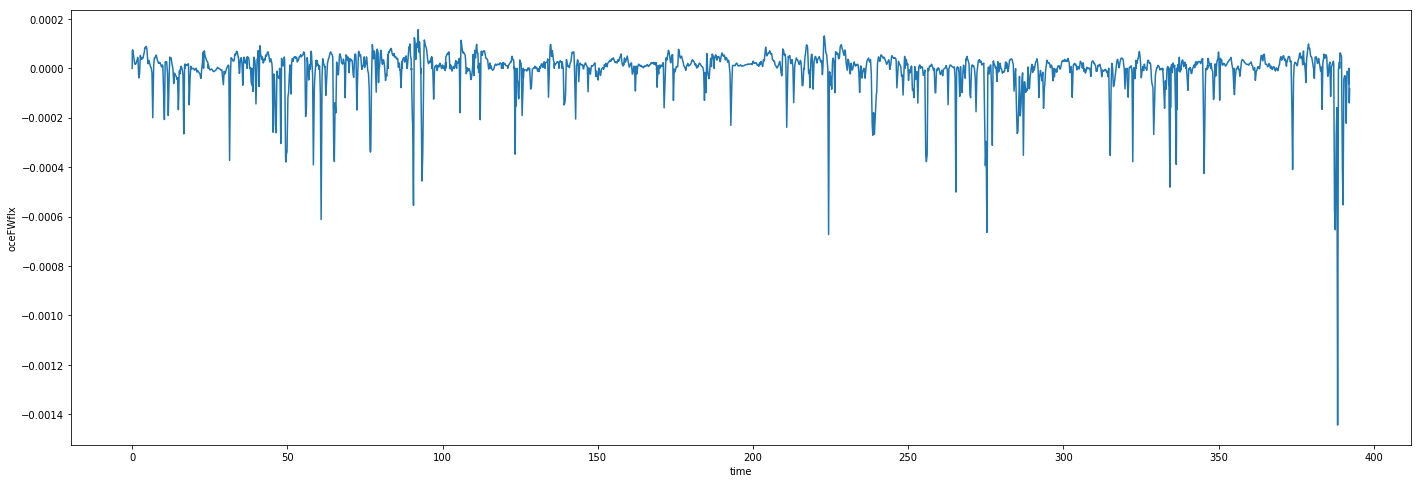

In [15]:
fig = plt.figure(figsize=(24,8))
%time ds[v].isel(lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [17]:
cluster.scheduler.close()

<Future finished result=None>